# Overview
In the last lecture of the class, we will discuss how to apply the modeling techniques we have studied to more complex stimuli than those that we have used so far. 

# Goals
We will model responses to a new data set from an experiment with a less structured design. This experiment has no pre-specified *conditions*; it shows a number of words, paired with pictures. Our goal will be to formally specify what *about* the words elicits responses in the brain. We will:

* Generate hypotheses about what features or aspects of the words are related to brain responses
* Fit a model based on a hypothesis to the data from the new experiment
* Use that model to predict responses to novel stimuli

This approach is called the *encoding model* approach. 

- Neuroscience concepts
    - Using feature spaces to represent the properties of complex stimulus
    - Modeling brain responses as a function of stimulus features
- Coding concepts
    - [none?]
- Datascience concepts
    - Predicting held out data
    - Testing and training sets
    - Testing model performance (using correlation)

In [1]:
# First: update neurods (new functions for computing OLS)
import neurods
_, _, version = [int(x) for x in neurods.__version__.split('.')]
if version <= 1:
    neurods.io.update_neurods()
# Restart your kernel!

In [1]:
# Imports
import neurods
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel
import cortex
# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline
from scipy.stats import zscore

# Complex Stimuli

The approach we have studied so far allows us to estimate responses to different categories of stimuli that have been shown in an experiment. We can compare responses between different conditions to test whether the brain reliably responds more to one condition compared to another, and we can predict the response of each voxel to new examples of the specific categories of stimuli that appear in our experiment. 

... But what if we are interested in more than responses to faces, bodies, places, and objects? What if we are interested in responses to more complex stimuli? For example, How might the brain respond when we speak, read, or listen to a variety of words? 

To explore this question, we will use freely available data from a paper from an influential paper (Mitchell et al. 2008, *Science*): https://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html

The experiment consists of subjects looking at a variety of words and accompanying line drawings of those words, as shown below.

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="http://www.cs.cmu.edu/~lwehbe/files/science.png")

Before we load the data for this experiment, we will discuss the way that we will describe (model) the stimulus.

In [3]:
### TEACHER INFO
# Delete me - only for Mark's laptop
neurods.io.data_list['fmri'] = '/Users/mark/gdrive/neuro_connector/data/fMRI/'

In [4]:
# Experiment directory
basedir = os.path.join(neurods.io.data_list['fmri'], 'word_picture')

In [5]:
# Here we load the 60 words that comprise our stimuli
feature_data = np.load(os.path.join(basedir, 'features.npz'))
words = feature_data['words']

print("Here are the stimulus words: \n")
print(words)

Here are the stimulus words: 

['airplane' 'ant' 'apartment' 'arch' 'arm' 'barn' 'bear' 'bed' 'bee'
 'beetle' 'bell' 'bicycle' 'bottle' 'butterfly' 'car' 'carrot' 'cat'
 'celery' 'chair' 'chimney' 'chisel' 'church' 'closet' 'coat' 'corn' 'cow'
 'cup' 'desk' 'dog' 'door' 'dress' 'dresser' 'eye' 'fly' 'foot' 'glass'
 'hammer' 'hand' 'horse' 'house' 'igloo' 'key' 'knife' 'leg' 'lettuce'
 'pants' 'pliers' 'refrigerator' 'saw' 'screwdriver' 'shirt' 'skirt'
 'spoon' 'table' 'telephone' 'tomato' 'train' 'truck' 'watch' 'window']


> Breakout session 1:
Working together with the whole class on the google doc, put the words into groups! Give each group a title (e.g. "Furniture"), and make a python list of strings for each group, like this:

    # Words that start with S (this is not a good reason to group words, it's just an example)
    group_1 = ['saw', 'screwdriver', 'shirt', 'skirt', 'spoon']
    
>Try to use *most* of the words in at least one group. These groups should have something in common that you think might affect responses in the brain!

In [11]:
# Fill in your groups!
group_1 = []
group_2 = []
# add as many groups as you want, up to ~5
groups = [group_1, group_2, ...]

In [6]:
### STUDENT ANSWER
place_words = ['apartment', 'barn', 'church', 'closet', 'igloo', 'house',
               'door', 'arch', 'window', 'chair', 'bed', 'chimney', 'refrigerator', 'dresser', 'desk', 'table',
              'bicycle', 'car', 'airplane', 'train', 'truck']
animal_words = ['ant', 'bear', 'bee', 'beetle', 'butterfly', 'dog', 'cat', 'cow', 'horse', 'fly']
body_words = ['arm', 'eye', 'hand', 'foot', 'leg',
              'skirt', 'shirt', 'pants', 'coat', 'dress']
food_tools = ['carrot', 'celery', 'bottle', 'corn', 'tomato', 'lettuce', 
             'key', 'knife', 'saw', 'screwdriver', 'chisel', 'cup', 'spoon', 'pliers', 'telephone', 'glass', 
             'bell', 'hammer', 'watch']
groups = [place_words, animal_words, body_words, food_tools]

In [7]:
# This function will convert your groups into an array that we can use to model the brain data from this experiment!
def group_to_design(*groups, words=words):
    """Convert lists of words in different groups into a design matrix
    
    Parameters
    ----------
    groups : lists
        any number of lists of strings can be input as the first argument. Each element
        of each group must be a word in the `words` list. 
    words : list
        The list of words to be divided into groups. 
        
    Returns
    -------
    """
    design = np.zeros((len(words), len(groups)))
    for igrp, grp in enumerate(groups):
        for grp_word in grp: 
            if not grp_word in words:
                raise Exception('{} is not in list!'.format(grp_word))
        design[:, igrp] = np.array([w in grp for w in words])
    return design

In [8]:
# ... and it can also be used to see what words you haven't yet categorized:
design = group_to_design(*groups)
print(words[~design.any(1)])

[]


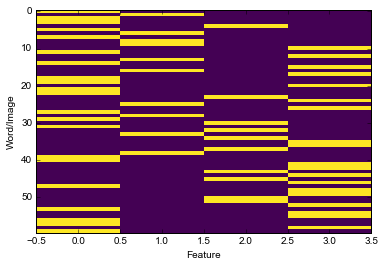

In [9]:
# Show feature assignments to each word
_ = plt.imshow(design)
plt.xlabel("Feature")
plt.ylabel("Word/Image")

# MOAR FEATURE DESCRIPTION

In [14]:
feature_names = feature_data['feature_names']
features = feature_data['features']
print("We have {0} features that describe the stimulus.\n".format(len(feature_names)))
print(feature_names[:11])

print("The features matrix therefore has {0} rows and {1} columns.\n".format(len(words), len(feature_names)))


feature_i = 10
print("FEATURE NUMBER {0}".format(feature_i))
print(feature_names[feature_i])
for i in range(20):
    print(words[i], features[i, feature_i])

We have 229 features that describe the stimulus.

['Is it an animal?' 'Is it a body part?' 'Is it a building?'
 'Is it a building part?' 'Is it clothing?' 'Is it furniture?'
 'Is it an insect?' 'Is it a kitchen item?' 'Is it manmade?'
 'Is it a tool?' 'Can you eat it?']
The features matrix therefore has 60 rows and 229.

FEATURE NUMBER 10
Can you eat it?
airplane 1
ant 3
apartment 1
arch 1
arm 1
barn 1
bear 2
bed 1
bee 1
beetle 2
bell 1
bicycle 1
bottle 1
butterfly 1
car 1
carrot 5
cat 2
celery 5
chair 1
chimney 1


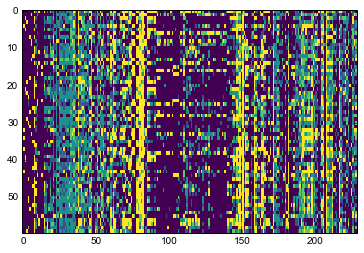

In [15]:
plt.imshow(feature_data['features'])

In [10]:
features = feature_data['features']
feature_names = feature_data['feature_names']
vis_features = features[:, 218:]
vis_feature_names = feature_names[218:]

print ("New features size is {0}".format(vis_features.shape))

New features size is (60, 11)


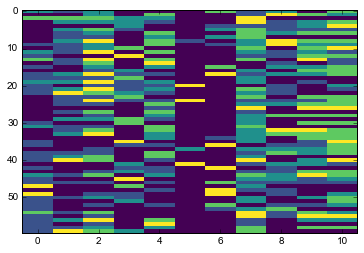

In [11]:
_ = plt.imshow(vis_features)

In this dataset, a stimulus was presented every 10 seconds, and the activity between 4 and 8 seconds after onset was averaged, resulting in one brain image for every stimulus presentation. Each stimulus was repeated 6 times, and the repetitions of all the stimuli was averaged.

This means that the hemodynamic response is *already accounted for*, because we are not dealing with raw TRs any more! Thus, no convolution of our design matrix will be necessary.

In [12]:
# Load the mask
mask_file = os.path.join(basedir,'s03_mask.nii')
mask = neurods.io.load_fmri_data(mask_file, do_zscore=False).astype(np.bool)

# Load the fMRI data
data_file = os.path.join(basedir,'s03.nii.gz')
data = neurods.io.load_fmri_data(data_file, do_zscore=True, mask=mask)
print(data.shape)

Loading /Users/mark/gdrive/neuro_connector/data/fMRI/word_picture/s03_mask.nii...
Loading /Users/mark/gdrive/neuro_connector/data/fMRI/word_picture/s03.nii.gz...
(60, 21764)


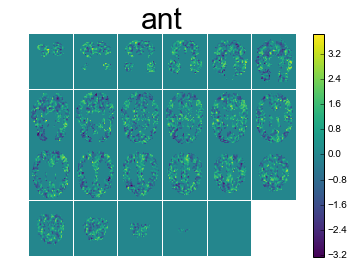

In [8]:
word_num = 1 # change the word number

sample_image = np.zeros(mask.shape)
sample_image[mask==True] = data[word_num]
h = cortex.mosaic(sample_image)
plt.colorbar();

plt.title(words[word_num], size=30)

In [13]:
# There are several new functions in neurods.stats that we have used the last few weeks.
from neurods import stats as nds

## BUILDING A PREDICTIVE MODEL

### IT IS VERY IMPORTANT NOT TO USE TEST DATA IN TRAINING!!

To test whether a model has learned a general relationship between stimulus features and brain responses, we need test it on data that was not included in the model training data set. 

Imagine you have a small dataset with voxel responses to features, and some of the voxels have some noise that is correlated to one of the features. The probability of such an event becomes smaller as the dataset size increases, but at low sample sizes there is a good chance of finding spurious correlations. 

Such a correlation would allow you to build a model that predicts brain activity from the features, but only in that dataset, since the noise is independent of the data and will not repeat in the same way in other datasets. However, for the voxels that show a real and strong enough response to the features, you will be able to learn a model that predicts brain activity from the features, and that model should generalize to new data.

This is why we always test a model on held out data that was not used in training. This allows us to judge whether the model is really predicting brain activity and not just fitted to noise in the sample.

Here we separate for you the words into a test and a train set:

In [14]:
test_index = [0, 1, 2, 3, 4, 6, 7, 8, 10, 13, 20, 23]
train_index = list(set(range(60)) - set(test_index))

train_x = zscore(design[train_index, :])
train_y = zscore(data[train_index, :])
print ("Shape of training features: {0}\nShape of training fMRI data: {1}".format(train_x.shape, train_y.shape))

test_x = zscore(design[test_index, :])
test_y = zscore(data[test_index, :])
print ("Shape of testing features: {0}\nShape of testing fMRI data: {1}".format(test_x.shape, test_y.shape))

Shape of training features: (48, 4)
Shape of training fMRI data: (48, 21764)
Shape of testing features: (12, 4)
Shape of testing fMRI data: (12, 21764)


### Weight estimation and data prediction

We want to learn a function that predicts the activity for any word in terms of its features. 


> Breakout session

- Use the `nds.ols()` function to estimate the brain response to the various features for every voxel.
- Use the estimated weights to predict the activity for the held-out words, using `test_X`.
- Use the `nds.compute_correlation()` function to compute the correlation of your predicted activity and the real activity `test_Y`
- Plot a flatmap of the prediction performance. Which regions are well predicted, why?

In [15]:
# Note: for pycortex plotting, this subject has been normalized to a standard template brain
# Thus, use a the template brain ("MNI" = Montreal Neurological Institute template) and standard atlas alignment
sub, xfm = 'MNI', 'atlas336'
# V = cortex.Volume(...)

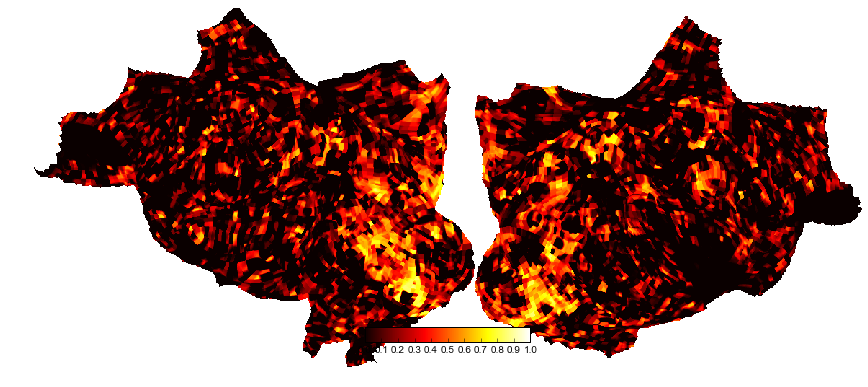

In [16]:
### STUDENT ANSWER
B = nds.ols(train_x, train_y)
pred_y = np.dot(test_x, B)
r = nds.compute_correlation(pred_y, test_y)
V = cortex.Volume(r, sub, xfm, cmap='hot', vmin=0, vmax=1.0, mask=mask)
_ = cortex.quickflat.make_figure(V)
# And/or:
def cxshow(dat, mask=mask, **kwargs):
    sub, xfm = 'MNI', 'atlas336'
    V = cortex.Volume(dat, sub, xfm, mask=mask, **kwargs)
    cortex.quickflat.make_figure(V)

# Cross validation
... the easy way:

In [17]:
from sklearn.model_selection import KFold
n_splits = 3
n_voxels = mask.sum()
# Pre-allocate 
r_cv = np.zeros((n_splits, n_voxels))
kf = KFold(n_splits=n_splits)
for icv, (trn, val) in enumerate(kf.split(range(12))):
    print("\n===Split {}===\n".format(icv))
    print("Training index:")
    print(trn)
    print("Validation index:")
    print(val)
    # Fit / predict the model here:
### STUDENT ANSWER    
    B_cv = nds.ols(zscore(design[trn]), zscore(data[trn]))
    pred_y = np.dot(zscore(design[val]), B_cv)
    r = nds.compute_correlation(pred_y, data[val])
    r_cv[icv, :] = r


===Split 0===

Training index:
[ 4  5  6  7  8  9 10 11]
Validation index:
[0 1 2 3]

===Split 1===

Training index:
[ 0  1  2  3  8  9 10 11]
Validation index:
[4 5 6 7]

===Split 2===

Training index:
[0 1 2 3 4 5 6 7]
Validation index:
[ 8  9 10 11]


In [18]:
### STUDENT ANSWER
def ols_cv(data, design, n_splits=3, ri=None):
    n_voxels = data.shape[1]
    if ri is not None:
        data_ = data[ri]
        design_ = design[ri]
    else:
        data_ = copy.copy(data)
        design_ = copy.copy(design)
    # Pre-allocate 
    r_cv = np.zeros((n_splits, n_voxels))
    kf = KFold(n_splits=n_splits)
    for icv, (trn, val) in enumerate(kf.split(design_)):
        B_cv = nds.ols(zscore(design_[trn]), zscore(data_[trn]))
        pred_y = np.dot(zscore(design_[val]), B_cv)
        r = nds.compute_correlation(pred_y, data_[val])
        r_cv[icv, :] = r
    return r_cv

# Model comparison

In [19]:
# We will use these groups as a null hypothesis (since it's not terribly likely that the brain cares about
# the alphabetic grouping of these words...)
dummy_groups = [['airplane', 'ant', 'apartment', 'arch', 'arm', 'barn', 'bear', 'bed', 'bee', 'beetle', 
                 'bell', 'bicycle', 'bottle', 'butterfly'],
                ['car', 'carrot', 'cat', 'celery', 'chair', 'chimney', 'chisel', 'church', 'closet', 
                 'coat', 'corn', 'cow', 'cup', 'desk', 'dog', 'door', 'dress', 'dresser'],
                ['eye', 'fly', 'foot', 'glass', 'hammer', 'hand', 'horse', 'house', 'igloo', 'key', 'knife',
                 'leg', 'lettuce','pants', 'pliers'],
                ['refrigerator', 'saw', 'screwdriver', 'shirt', 'skirt', 'spoon', 'table', 
                 'telephone', 'tomato', 'train', 'truck', 'watch', 'window']]
dummy_design = group_to_design(*dummy_groups)

In [20]:
### STUDENT ANSWER
# Solution to bad grouping of features in trn/test sets
ri = np.random.permutation(60)
# data = data[ri]
# design = design[ri]
# dummy_design = dummy_design[ri]

In [21]:
# Fit all three models w/ cross validation
r_class_model = ols_cv(data, design, ri=ri)
r_dummy = ols_cv(data, dummy_design, ri=ri)
r_fancy = ols_cv(data, vis_features, ri=ri)

(-0.6, 0.85)

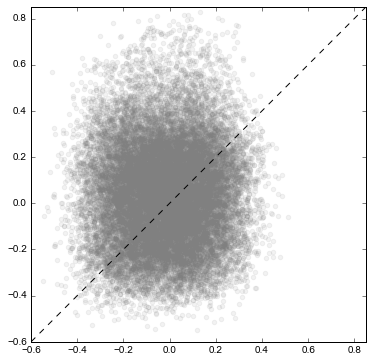

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(r_dummy.mean(0), r_class_model.mean(0), color='gray', alpha=0.1)
plt.plot([-0.6,0.85], [-0.6,0.85], 'k--')
plt.xlim([-0.6,0.85])
plt.ylim([-0.6,0.85])

(-0.6, 0.85)

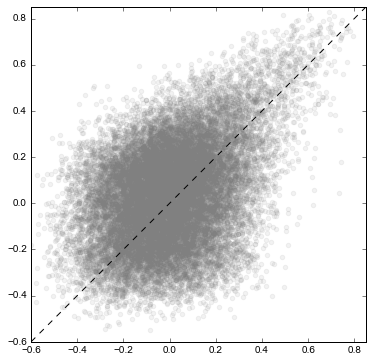

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(r_fancy.mean(0), r_class_model.mean(0), color='gray', alpha=0.1)
plt.plot([-0.6,0.85], [-0.6,0.85], 'k--')
plt.xlim([-0.6,0.85])
plt.ylim([-0.6,0.85])

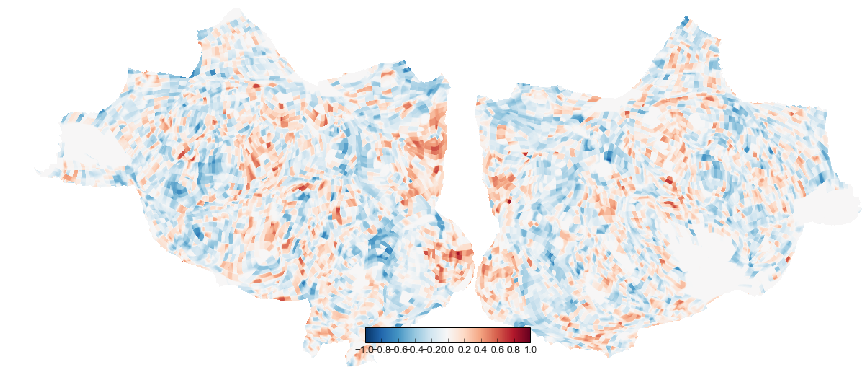

In [28]:
V = cortex.Volume(r_fancy.mean(0)-r_class_model.mean(0), sub, xfm, cmap='RdBu_r', vmin=-1, vmax=1, mask=mask)
_ = cortex.quickflat.make_figure(V)

# Model interpretation (??)

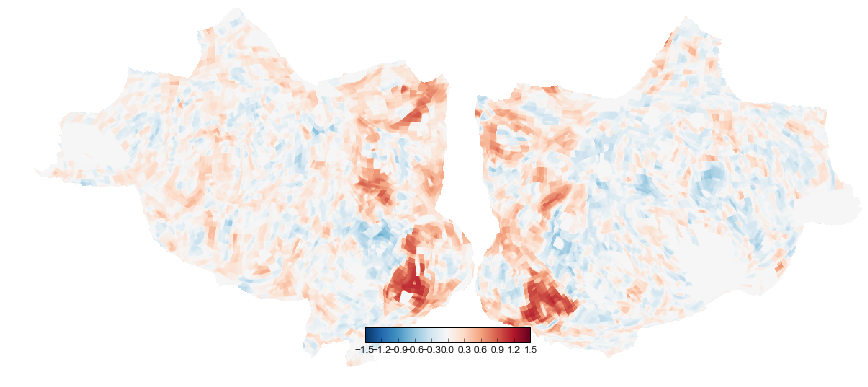

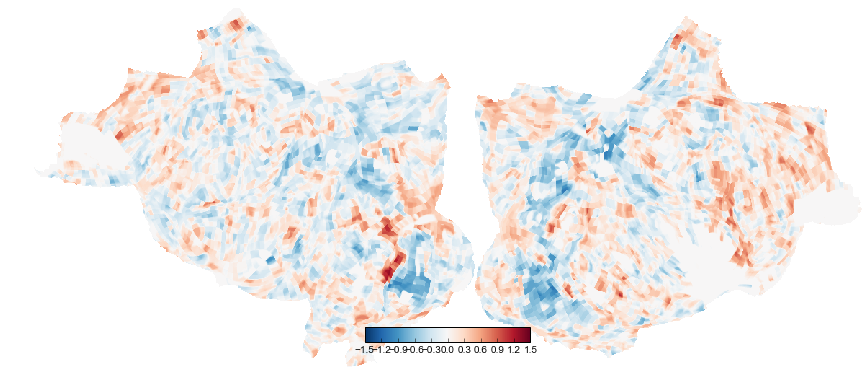

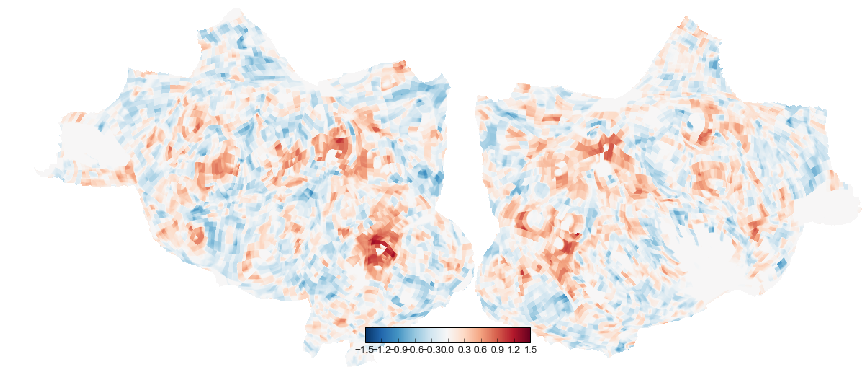

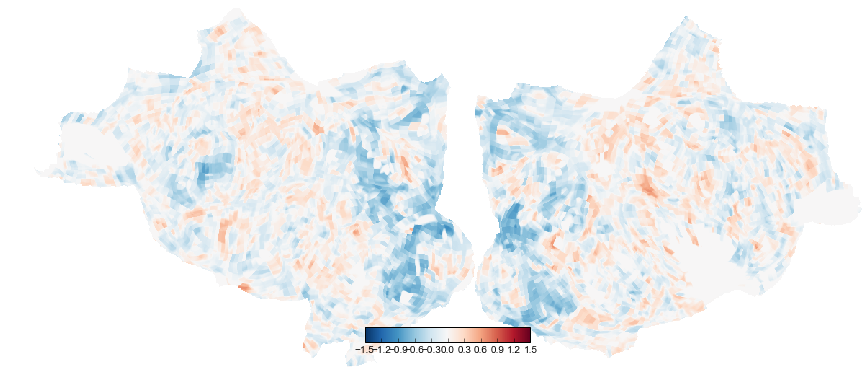

In [41]:
sub, xfm = 'MNI', 'atlas336',
for b in B:
    V = cortex.Volume(b, sub, xfm, cmap='RdBu_r', vmin=-1.5, vmax=1.5, mask=mask)
    cortex.quickflat.make_figure(V)

In [40]:
V = cortex.Volume(sample_image, 'MNI', 'atlas336')